# Writer Identification based on their Handwriting


In [64]:
#imports
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import os

In [73]:
#paths
IAM_PATH = "/mounts/layout/dkvart/data/IAM"
CVL_PATH = "/mounts/layout/dkvart/data/CVL"

In [120]:
#Given a path to a directory, randomly display the samples 
def display_rand_images(PATH, R=4, C=2, size=(10,10)):
    temp = 0
    MAX_SHOW = R * C
    
    #matplot figure configuration
    figure = plt.figure(figsize=(size))
    
    #create a numpy array and shuffle
    filenames = np.array(os.listdir(PATH))
    np.random.shuffle(filenames)
    
    for i, filename in enumerate(filenames[:MAX_SHOW], 1):
        handwriting_sample = mpimg.imread(PATH+filename)
        figure.add_subplot(R, C, i)
        plt.imshow(handwriting_sample)
    plt.show()

# IAM handwriting samples

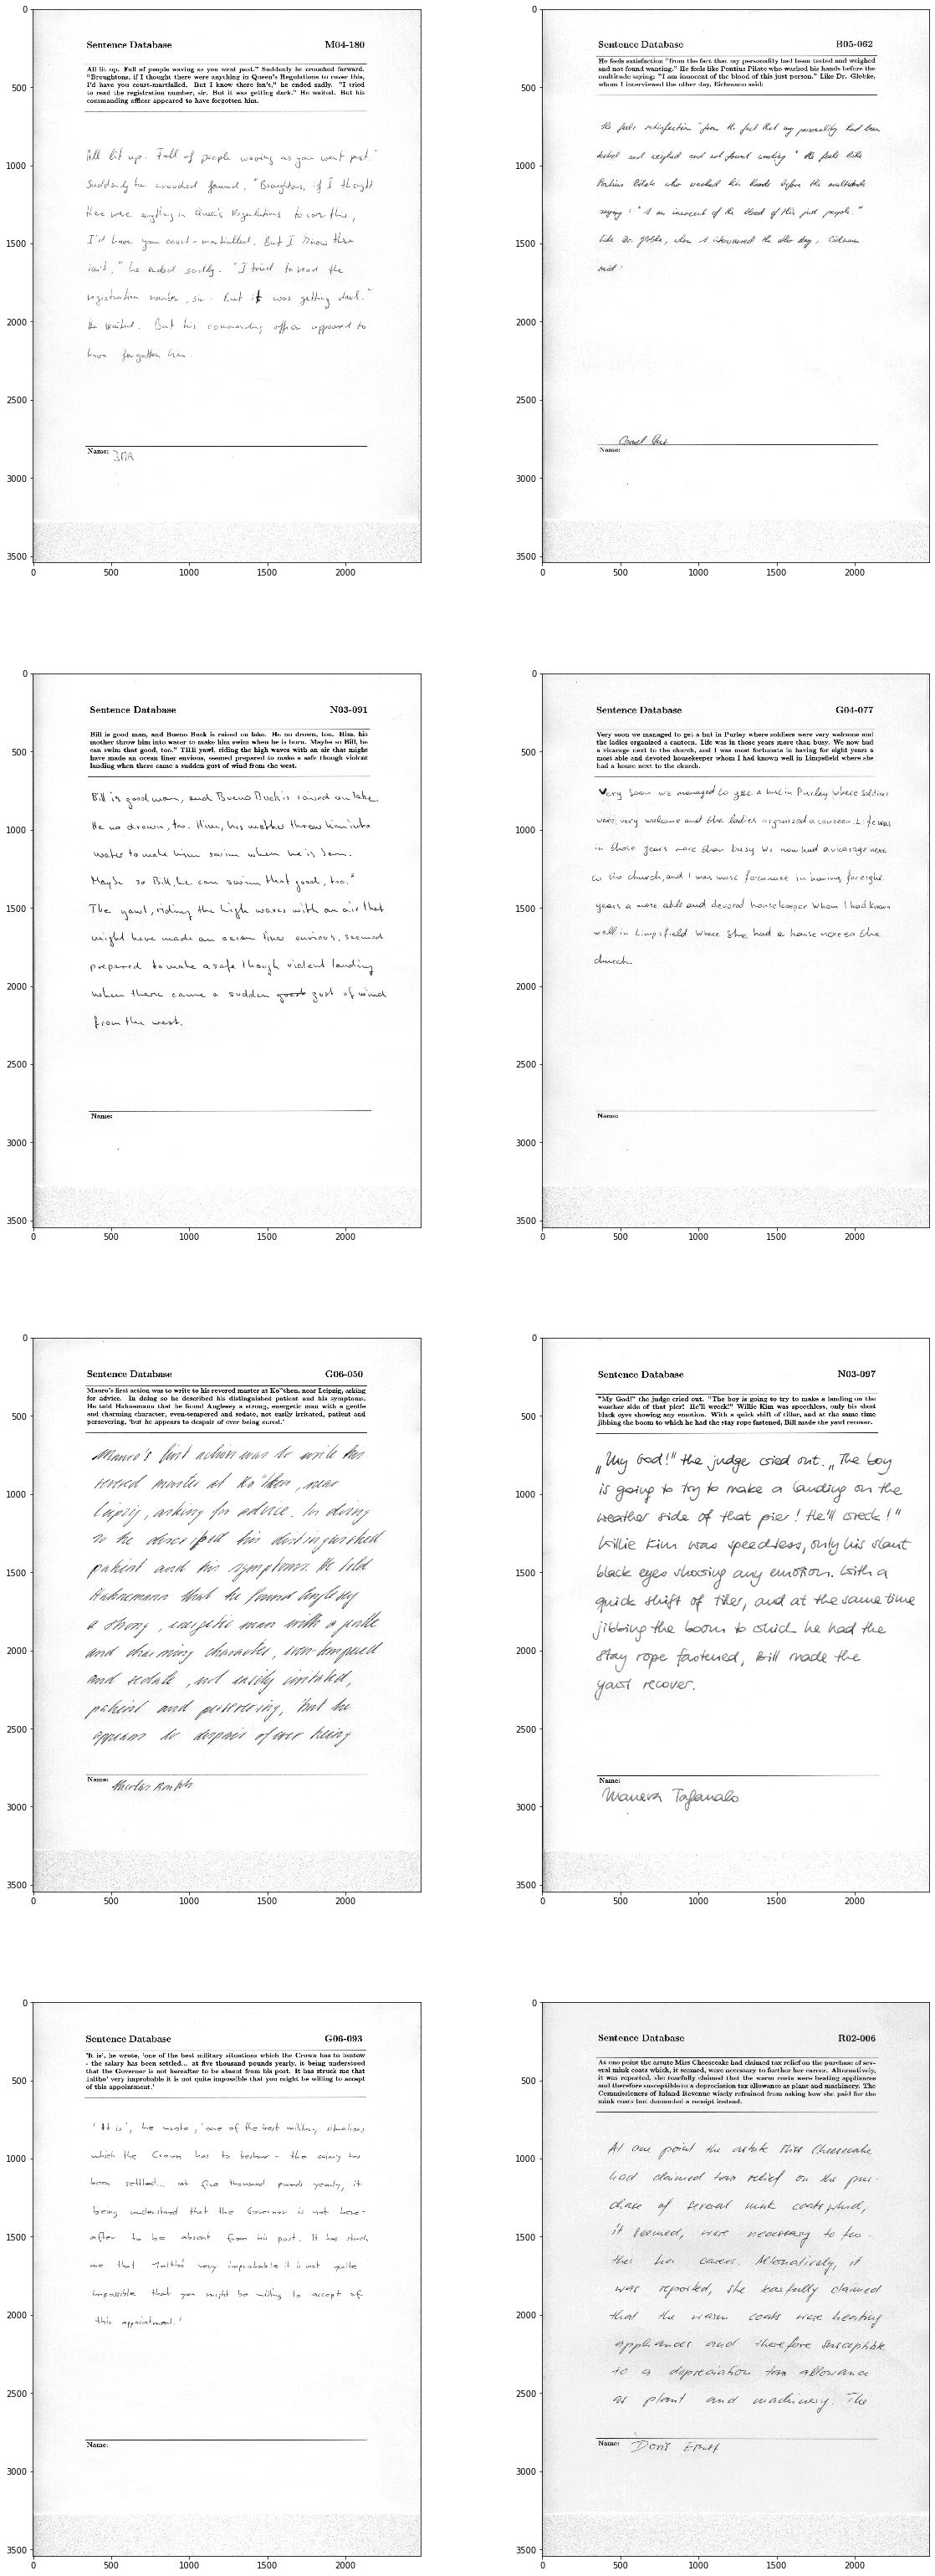

In [89]:
display_rand_images(IAM_PATH)

# CVL handwriting samples

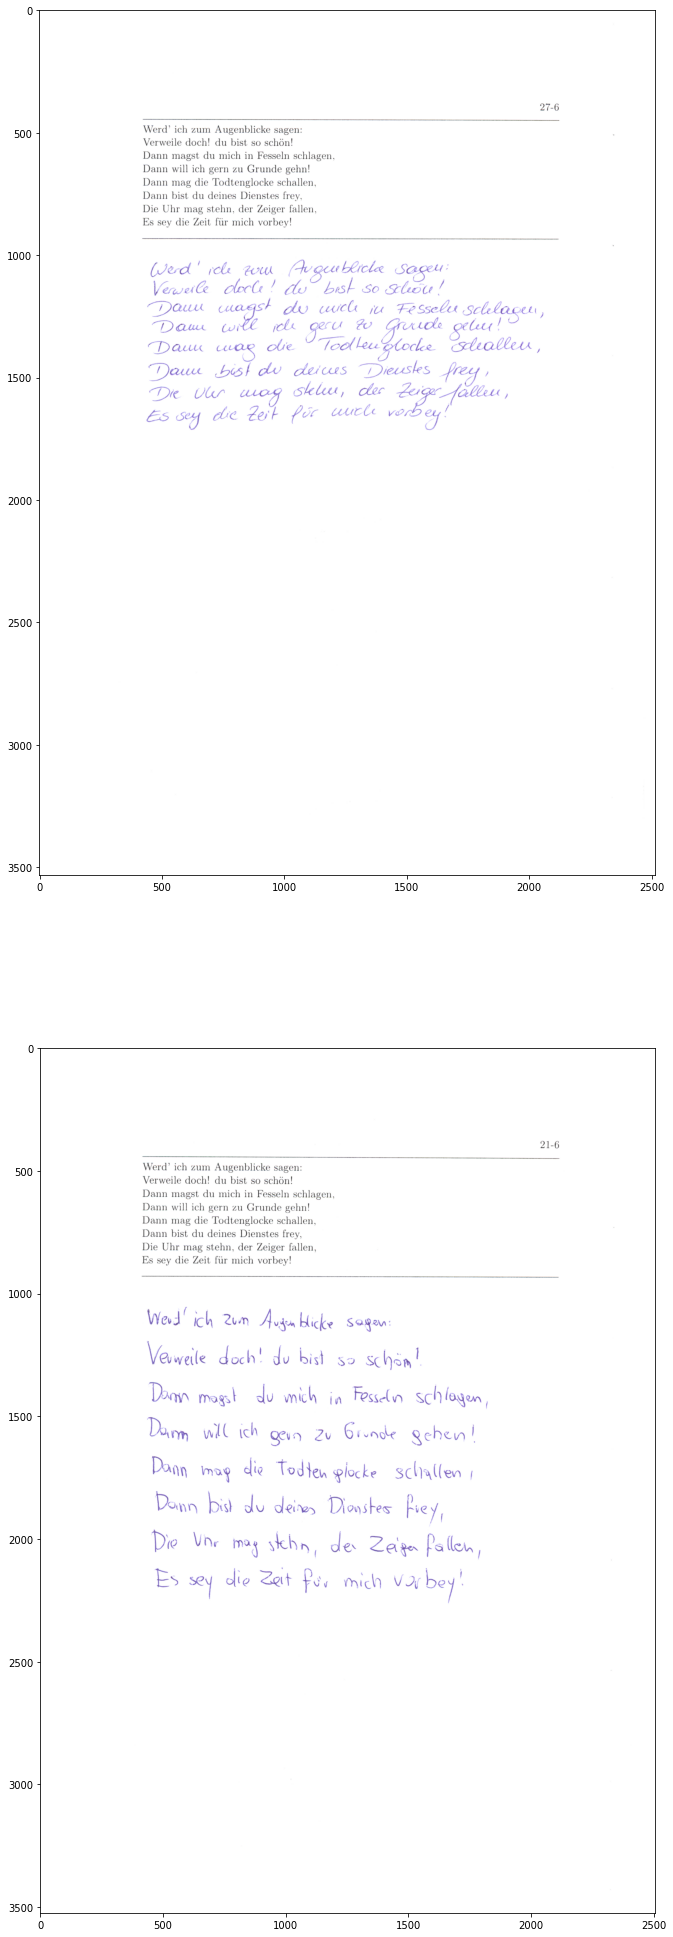

In [154]:
display_rand_images(CVL_PATH+"/trainset/pages/", R=2,C=1, size=(50,35))

In [87]:
def parse_filenames(DATA_ORIGIN, filenames):
    writer_ids = []
    for filename in filenames:
        if DATA_ORIGIN == "IAM":
            next_id = filename.split('-')[1][:3]
        elif DATA_ORIGIN == "CVL":
            next_id = filename.split('-')[0]
        
        writer_ids.append(int(next_id))
            
    return writer_ids

# Function: reads all handwriting samples.
# Argument: a path to a directory where the data lives.
# Return: a tuple (writer_ids, filenames) where the first element is a numpy array of 
# writer ids and second element - a numpy array of each sample filename. These two arrays
# correspond to each other.
def read_all_samples(DATA_ORIGIN, PATH):
    filenames = os.listdir(PATH)    
    writer_ids = parse_filenames(DATA_ORIGIN, filenames)    
    
    return (np.array(writer_ids), np.array(filenames))            

In [90]:
writer_ids, sample_filenames = read_all_samples("CVL", CVL_PATH+"/trainset/pages/") #DO I NEED THESE FUNCTIONS?

# Preprocessing

In [139]:
import cv2

# Function: resizes an image to the specified new width, but also scales the 
#           image accordingly. 
def resize_image_to_width(img, NEW_WIDTH):
    h,w = img.shape
    NEW_HEIGHT = int((h/w)*NEW_WIDTH)
    return cv2.resize(img, (NEW_WIDTH, NEW_HEIGHT), interpolation = cv2.INTER_AREA)

# Function: Concatenate lines into one long page of a given width.
# Argument: PATH - to a directory with the images of lines.
#           NEW_WIDTH - the lines are of variable length, and all need to be resized to the same width.
def concatenate_lines(PATH, NEW_WIDTH):
    writer_ids, sample_filenames = read_all_samples("CVL", PATH)
    np.random.shuffle(sample_filenames)
    
    concatenated_image = cv2.imread(PATH+sample_filenames[0], cv2.IMREAD_GRAYSCALE)
    concatenated_image = resize_image_to_width(concatenated_image, NEW_WIDTH)
    
    for filename in sample_filenames[1:]:
        next_image = cv2.imread(PATH+filename, cv2.IMREAD_GRAYSCALE)
        
        #add a line to the final image, only if the 
        if(next_image.shape[1] < 2.5*NEW_WIDTH):
            continue
            
        resized_image = resize_image_to_width(next_image, NEW_WIDTH)      
        concatenated_image = cv2.vconcat([concatenated_image, resized_image])
        
    return concatenated_image

def split_image(img):
    images = []
    h, w = img.shape
    left = img[:, :w//3]
    mid = img[:, w//3:2*w//3]
    right = img[:, 2*w//3:]
    
    fixed_height = w//3
    for i in range(h//fixed_height-2):
        images.append(left[i*fixed_height:(i+1)*fixed_height, :])
        images.append(mid[(i+1)*fixed_height:(i+2)*fixed_height, :])
        images.append(right[(i+2)*fixed_height:(i+3)*fixed_height, :])
    
    return images

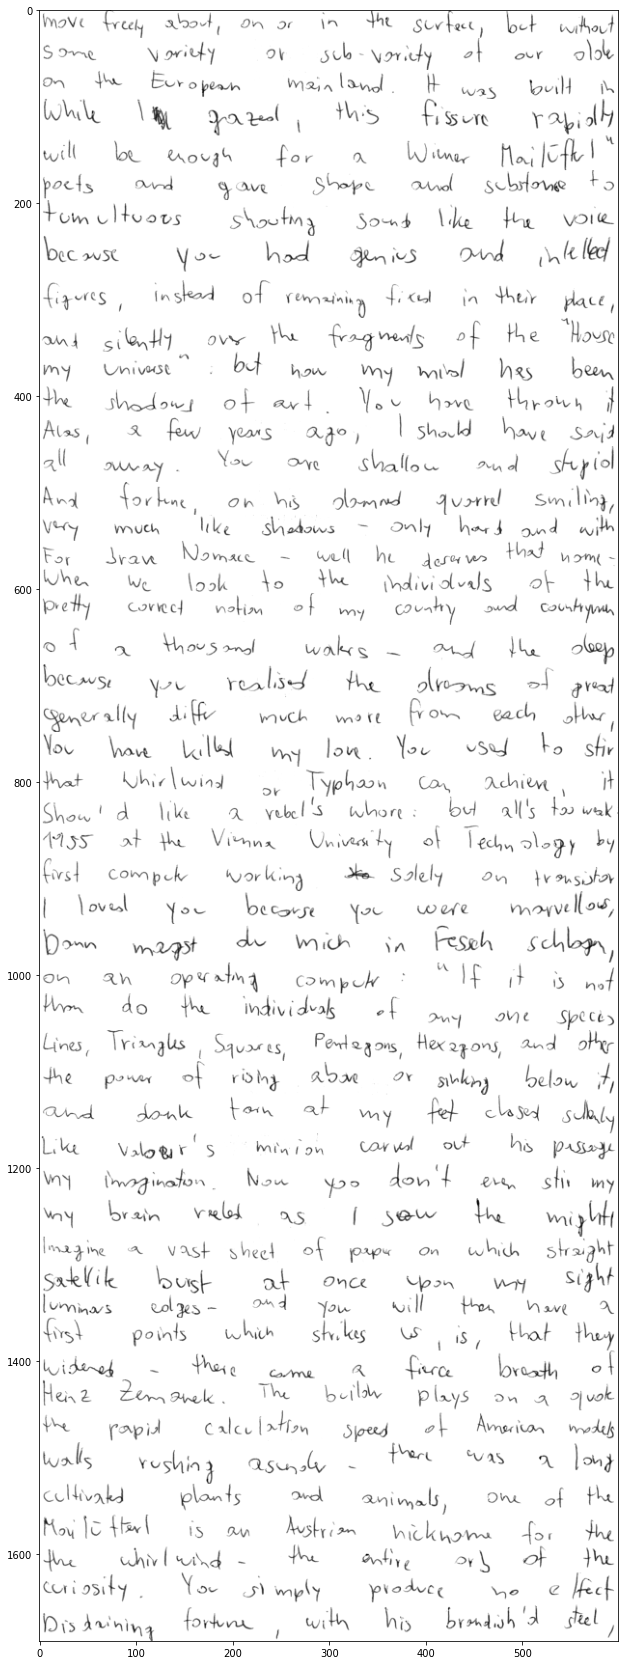

In [157]:
img = concatenate_lines(CVL_PATH+"/trainset/lines/0001/", 600)
plt.figure(figsize=(30, 30))
plt.imshow(img, cmap='gray')
# Below you can see how I concatenated lines
# into a long page. 

In [164]:
images = split_image(img)

These are the final patches that I acquired by splitting the image into three long stripes and then cutting them horizontally in a way that I get the square images. They contain 8-15 words. I think this might be too much variability.

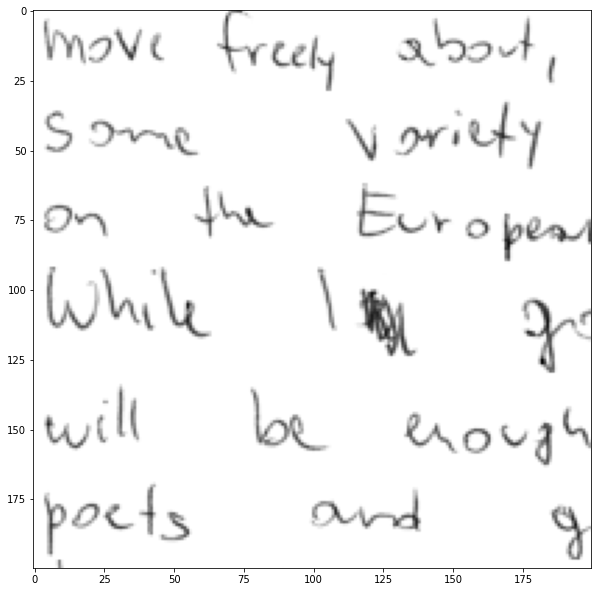

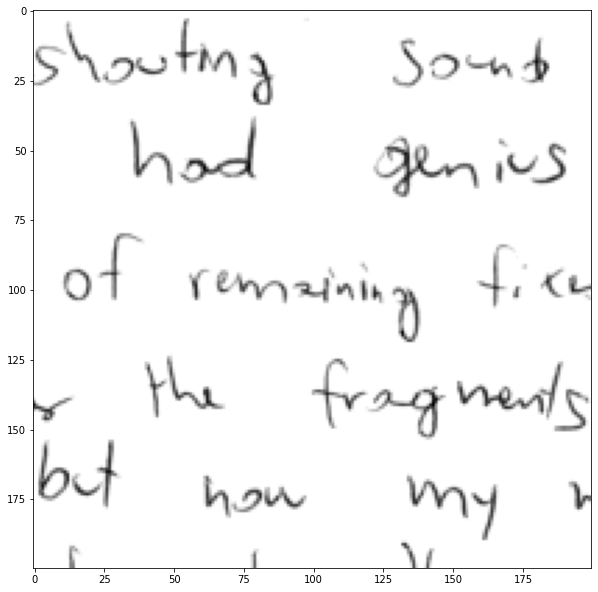

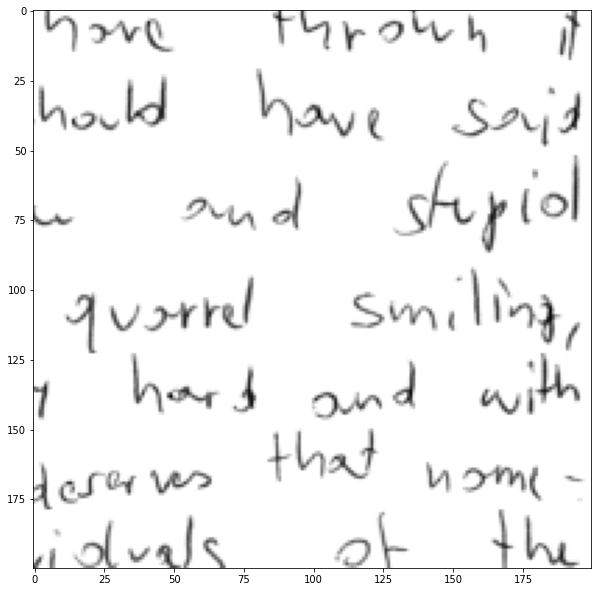

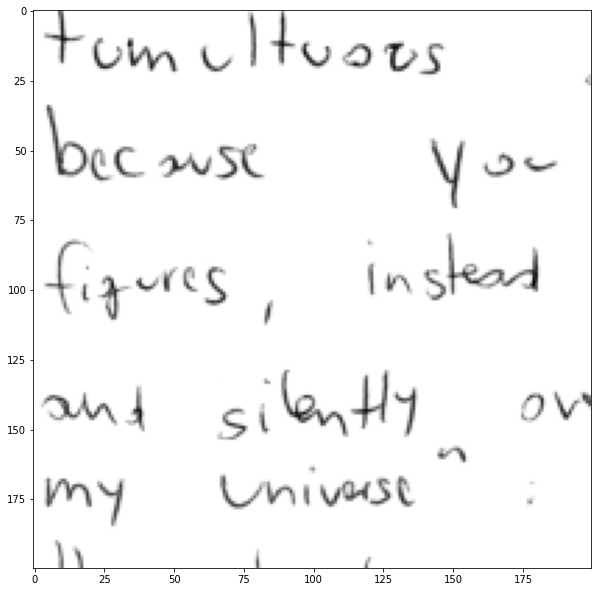

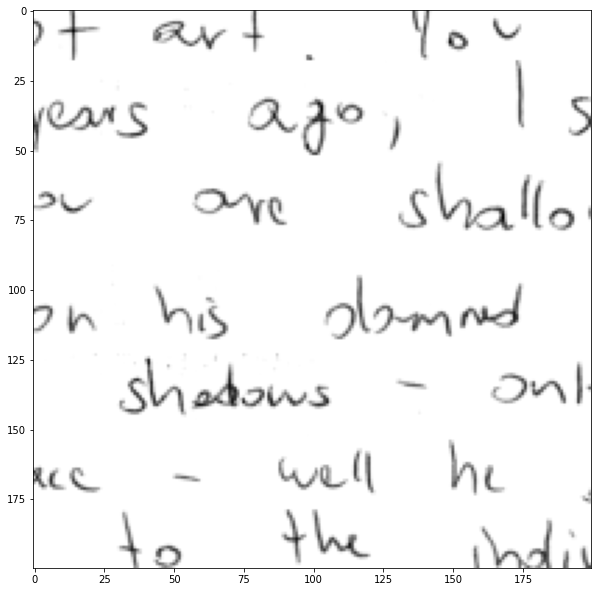

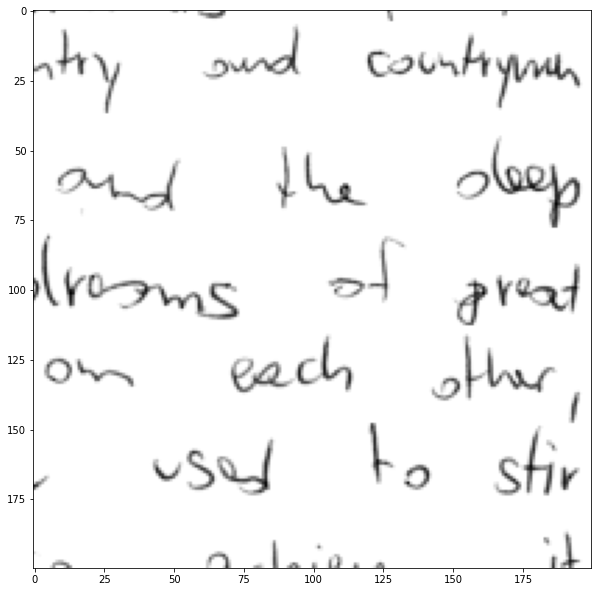

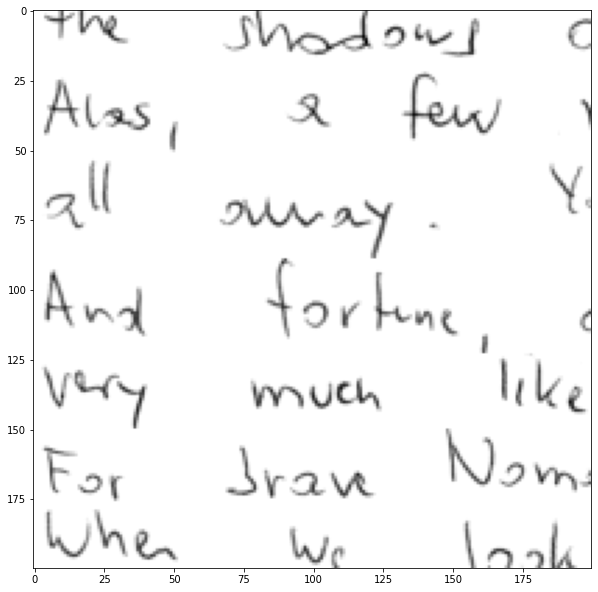

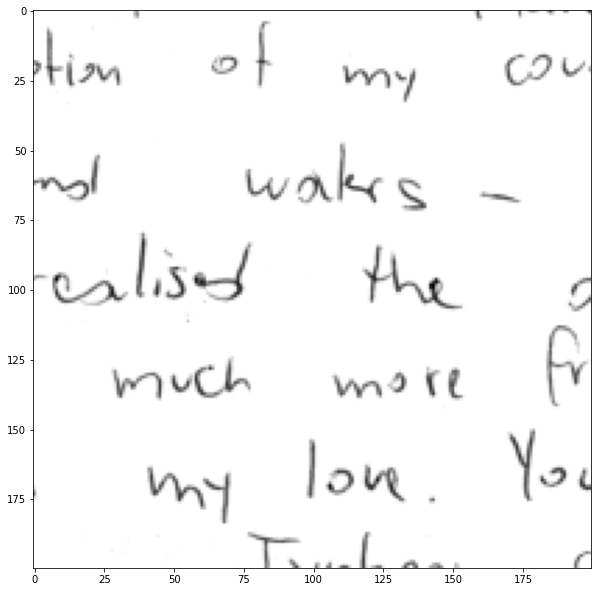

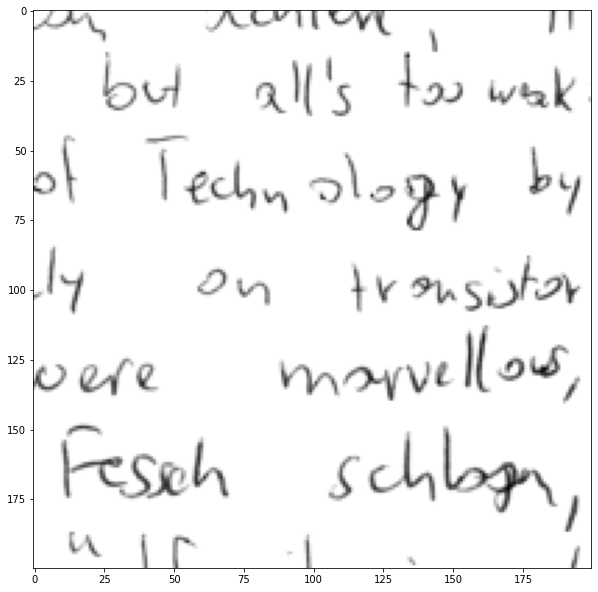

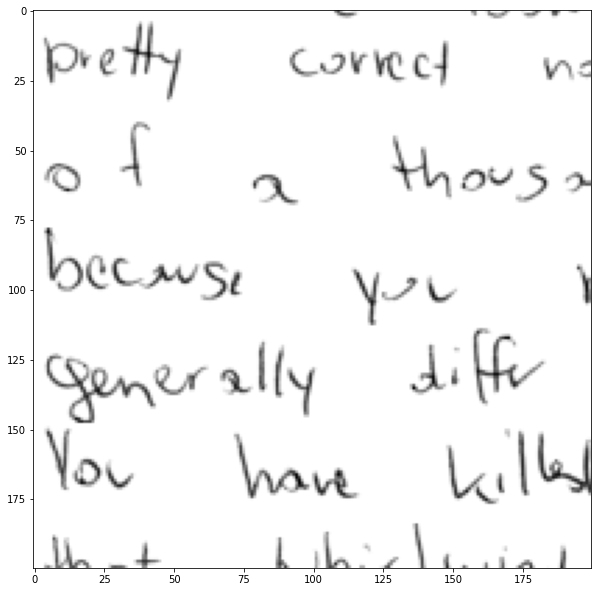

In [168]:
for image in images[:10]:
    plt.figure(figsize=(10, 20))
    plt.imshow(image, cmap='gray')

In [126]:
def save_images(PATH, writer_id, images):
    counter = 0
    os.mkdir(PATH+writer_id)
    for image in images:
        counter+=1
        filename = PATH+writer_id+'/'+writer_id+'-'+str(counter)+'.jpg'
        cv2.imwrite(filename, image)
        
def create_patches(N):
    PATH = CVL_PATH+"/trainset/lines/"
    directories = os.listdir(PATH)
    for writer_id in directories:
        all_patches = []
        for i in range(N):
            conc_image = concatenate_lines(PATH+writer_id+'/', 600)
            mini_patches = split_image(conc_image)
            all_patches.extend(mini_patches)
        save_images(CVL_PATH+"/trainset/processed/", writer_id, all_patches)
create

# Regular classification via CNN

In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
data = datagen.flow_from_directory("/mounts/layout/dkvart/dkvart/CVL/processed/", target_size=(900,900), batch_size=32)

Found 8661 images belonging to 27 classes.


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [39]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(900, 900, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(27))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(data, epochs=10)

NameError: name 'data' is not defined

In [45]:
#FROM TENSORFLOW
# import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [46]:
import pathlib
data_dir = pathlib.Path("/mounts/layout/dkvart/dkvart/CVL/processed")

In [47]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8661


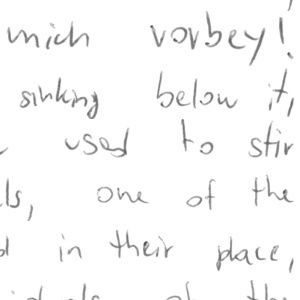

In [48]:
w1 = list(data_dir.glob('0001/*'))
PIL.Image.open(str(w1[0]))

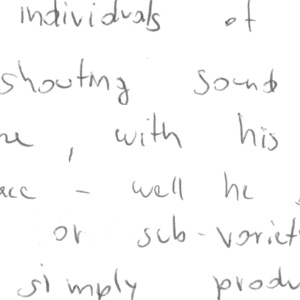

In [49]:
PIL.Image.open(str(w1[1]))

In [50]:
batch_size = 16
img_height = 200
img_width = 200

In [51]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# train_ds = train_ds.shuffle(150, reshuffle_each_iteration=False)


Found 8661 files belonging to 27 classes.
Using 6929 files for training.


In [34]:
class_names = train_ds.class_names
print(class_names)

['0001', '0002', '0003', '0004', '0005', '0006', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0041', '0042', '0047', '0050']


In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8661 files belonging to 27 classes.
Using 1732 files for validation.


In [53]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 200, 200, 3)
(16,)


In [54]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
num_classes = 27
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation=None),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
  layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
])

In [58]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tfa.losses.TripletSemiHardLoss())

In [59]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
# import numpy as np
# import io
# # single_batch = val_ds.take(1)

# results = model.predict(val_ds)
# np.savetxt("vecs.tsv", results, delimiter='\t')
# import tensorflow_datasets as tfds

# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for img, labels in tfds.as_numpy(single_batch):
#     [out_m.write(str(x) + "\n") for x in labels]
# out_m.close()

# try:
#     from google.colab import files
#     files.download('vecs.tsv')
#     files.download('meta.tsv')
# except:
#     pass

Epoch 1/10
434/434 [==============================] - 17s 38ms/step - loss: nan - val_loss: 1.0000
Epoch 2/10
110/434 [======>.......................] - ETA: 11s - loss: nan

KeyboardInterrupt: 

In [267]:
# img, labels = single_batch
for img, labels in single_batch:
    for x in labels:
        print(x)
    
for img, labels in tfds.as_numpy(single_batch):
    print(labels)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
[1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0]


In [264]:
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in bla:
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()